In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
df = pd.read_csv('event_data_train.csv')

In [40]:
df.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


In [42]:
df['data'] = pd.to_datetime(df.timestamp, unit='s')

In [43]:
df.head()

,step_id,timestamp,action,user_id,data
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [44]:
print('Strart of the course:', df.data.min())
print('Last action:', df.data.max())

Strart of the course: 2015-06-15 04:00:48
Last action: 2018-05-19 23:33:31


In [45]:
df['day'] = df.data.dt.date

<AxesSubplot:xlabel='day'>

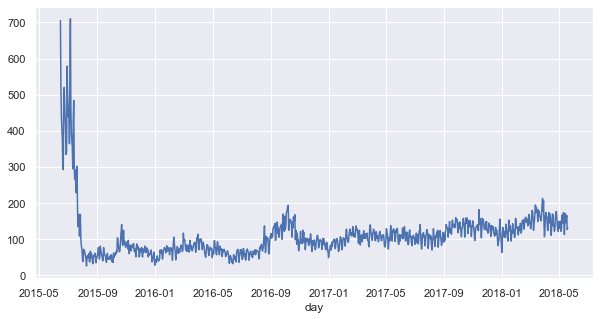

In [46]:
sns.set(rc={'figure.figsize': (10, 5)})

df.groupby('day').user_id.nunique().plot(c='b')

In [17]:
df.pivot_table(index='user_id', columns='action', 
               values='step_id', aggfunc='count', fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

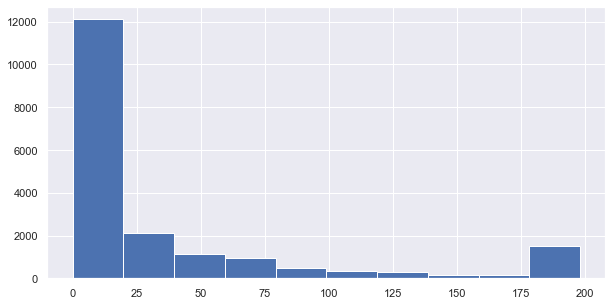

In [18]:
df.pivot_table(index='user_id', columns='action', 
               values='step_id', aggfunc='count', fill_value=0).reset_index().discovered.hist()

In [20]:
df2 = pd.read_csv('submissions_data_train.csv')

In [21]:
df2.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [22]:
df2['data'] = pd.to_datetime(df2.timestamp, unit='s')

In [23]:
df2['day'] = df2.data.dt.date

In [24]:
df2.head()

,step_id,timestamp,submission_status,user_id,data,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [25]:
users_scores = df2.pivot_table(index='user_id', columns='submission_status', 
               values='step_id', aggfunc='count', fill_value=0).reset_index().head()

In [26]:
gap_data = df2[['user_id', 'day', 'timestamp']]\
.drop_duplicates(subset=['user_id', 'day'])\
.groupby('user_id')['timestamp'].apply(list)\
.apply(np.diff).values

In [27]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

gap_data = gap_data / (34 * 3600)

<AxesSubplot:>

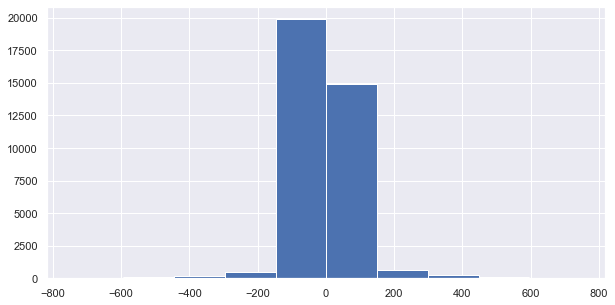

In [28]:
gap_data.hist()

In [29]:
gap_data.quantile(0.9)

20.59062091503269

In [30]:
df2[df2.submission_status == 'correct']\
.groupby('user_id').agg({'submission_status':'count'})\
.sort_values(by=['submission_status'], ascending=False)\
.reset_index(0).head()

,user_id,submission_status
0,1046,421
1,5552,186
2,17135,168
3,6183,142
4,8461,135


In [31]:
users_data = df2.groupby('user_id', as_index=False)\
.agg({'timestamp' : 'max'})\
.rename(columns={'timestamp' : 'last_timestamp'})

In [32]:
now = 1526772811
threshhold = 2592000

In [33]:
users_data['is_gone'] = (now - users_data.last_timestamp) > threshhold

In [34]:
users_data.head()

,user_id,last_timestamp,is_gone
0,2,1514383485,True
1,3,1444573728,True
2,5,1499859730,True
3,8,1480604143,True
4,14,1436368601,True


In [35]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [36]:
users_data.merge(users_scores ,how='outer').fillna(0)

,user_id,last_timestamp,is_gone,correct,wrong
0,2,1514383485,True,2.0,0.0
1,3,1444573728,True,29.0,23.0
2,5,1499859730,True,2.0,2.0
3,8,1480604143,True,9.0,21.0
4,14,1436368601,True,0.0,1.0
...,...,...,...,...,...
9935,26787,1469015051,True,0.0,0.0
9936,26790,1451722691,True,0.0,0.0
9937,26794,1511374868,True,0.0,0.0
9938,26797,1508425828,True,0.0,0.0


In [47]:
df.head()

,step_id,timestamp,action,user_id,data,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [48]:
df['user_time'] = df.user_id.map(str) + '_' + df.timestamp.map(str)

In [49]:
df.head()

,step_id,timestamp,action,user_id,data,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [50]:
learning_time_treshhold = 3 * 24 * 60 * 60

In [52]:
users_min_time = df.groupby('user_id', as_index=False).agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'}, axis=1)

In [53]:
users_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [54]:
user_learning_time_treshhold = users_min_time.user_id.map(str) + '_' + (users_min_time.min_timestamp + learning_time_treshhold).map(str)

In [56]:
users_min_time['user_learning_time_treshhold'] = user_learning_time_treshhold

In [61]:
df = df.merge(users_min_time[['user_id', 'user_learning_time_treshhold']])

In [62]:
df.head()

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_treshhold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [63]:
df_train = df[df.user_time <= df.user_learning_time_treshhold]

In [64]:
df_train.head()

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_treshhold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [72]:
X = df2.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})

In [73]:
X.head()

,user_id,days
0,2,1
1,3,5
2,5,1
3,8,1
4,14,1


In [74]:
step_tried = df2.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id':'steps_tried'})

In [76]:
step_tried.head()

,user_id,steps_tried
0,2,2
1,3,29
2,5,2
3,8,11
4,14,1


In [77]:
X = X.merge(step_tried, on='user_id', how='outer')

In [78]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,5,29
2,5,1,2
3,8,1,11
4,14,1,1


In [79]:
X.shape

(9940, 3)

In [83]:
X = X.merge(df2.pivot_table(index='user_id', columns='submission_status', 
               values='step_id', aggfunc='count', fill_value=0).reset_index())

In [84]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,5,29,29,23
2,5,1,2,2,2
3,8,1,11,9,21
4,14,1,1,0,1


In [85]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [86]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,5,29,29,23,0.557692
2,5,1,2,2,2,0.500000
3,8,1,11,9,21,0.300000
4,14,1,1,0,1,0.000000


In [87]:
X = X.merge(df.pivot_table(index='user_id', columns='action', 
               values='step_id', aggfunc='count', fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [88]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,10
1,3,5.0,29.0,29.0,23.0,0.557692,192
2,5,1.0,2.0,2.0,2.0,0.500000,12
3,8,1.0,11.0,9.0,21.0,0.300000,156
4,14,1.0,1.0,0.0,1.0,0.000000,9


In [89]:
X.shape

(19234, 7)

In [91]:
X = X.fillna(0)

In [92]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,10
1,3,5.0,29.0,29.0,23.0,0.557692,192
2,5,1.0,2.0,2.0,2.0,0.500000,12
3,8,1.0,11.0,9.0,21.0,0.300000,156
4,14,1.0,1.0,0.0,1.0,0.000000,9
